<a href="https://colab.research.google.com/github/giugliarelligabriele/tennis-surface-evolution/blob/main/notebooks/tennis_surface_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎾 Serving Through Change: The Evolution and Convergence of ATP Surfaces (2000–2024)

**Author:** Gabriele Giugliarelli  
**Objective:** Analyze ATP match data (2000–2024) to understand how the key factors for victory have evolved across surfaces,  
and whether the convergence of surfaces represents a *necessary response* to increasing player power and serve dominance.  

**Dataset:** [Jeff Sackmann – ATP Matches](https://github.com/JeffSackmann/tennis_atp)

---

### Project Overview
The project includes:
1. Building a balanced **player-level dataset** (winners + losers)  
2. **Exploratory Data Analysis** on serve and return statistics over time  
3. **Random Forest modeling** to estimate feature importance by surface and year  
4. **Visualization** of long-term trends using 3-year moving averages  
5. **Interpretation** of results: surface convergence as an adaptation to the rising power of the modern game


In [122]:
# Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')

# Visualization settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

%matplotlib inline


In [123]:
# Download ATP match data (2000–2024)

os.makedirs("data", exist_ok=True)
base_url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/"
years = range(2000, 2025)

for year in years:
    filename = f"atp_matches_{year}.csv"
    url = base_url + filename
    !wget -q -O data/{filename} {url}

print("✅ Download completed for 2000–2024.")


✅ Download completed for 2000–2024.


In [124]:
# Download ATP match data (2000–2024)

os.makedirs("data", exist_ok=True)
base_url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/"
years = range(2000, 2025)

for year in years:
    filename = f"atp_matches_{year}.csv"
    url = base_url + filename
    !wget -q -O data/{filename} {url}

print("✅ Download completed for 2000–2024.")
# Combine all yearly CSVs into one DataFrame

all_dfs = []
for year in years:
    df = pd.read_csv(f"data/atp_matches_{year}.csv")
    df["year"] = year
    all_dfs.append(df)

matches = pd.concat(all_dfs, ignore_index=True)
print("Shape:", matches.shape)
matches.info()
# Check missing values
matches.isna().mean().sort_values(ascending=False).head(15)
matches.head()

✅ Download completed for 2000–2024.
Shape: (74906, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74906 entries, 0 to 74905
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          74906 non-null  object 
 1   tourney_name        74906 non-null  object 
 2   surface             74853 non-null  object 
 3   draw_size           74906 non-null  int64  
 4   tourney_level       74906 non-null  object 
 5   tourney_date        74906 non-null  int64  
 6   match_num           74906 non-null  int64  
 7   winner_id           74906 non-null  int64  
 8   winner_seed         31120 non-null  float64
 9   winner_entry        9506 non-null   object 
 10  winner_name         74906 non-null  object 
 11  winner_hand         74906 non-null  object 
 12  winner_ht           73481 non-null  float64
 13  winner_ioc          74906 non-null  object 
 14  winner_age          74901 non-null  float64
 15

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1.0,NaN,Tommy Haas,R,188.0,GER,21.7,101543,NaN,NaN,Jeff Tarango,L,180.0,USA,31.1,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0,2000
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,Juan Balcells,R,190.0,ESP,24.5,102644,NaN,NaN,Franco Squillari,L,183.0,ARG,24.3,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0,2000
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,Alberto Martin,R,175.0,ESP,21.3,102238,NaN,NaN,Alberto Berasategui,R,173.0,ESP,26.5,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0,2000
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7.0,NaN,Juan Carlos Ferrero,R,183.0,ESP,19.9,103819,NaN,NaN,Roger Federer,R,185.0,SUI,18.4,6-4 6-4,3,R32,68.0,5.0,1.0,53.0,28.0,26.0,15.0,10.0,0.0,0.0,11.0,2.0,70.0,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0,2000
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,Michael Sell,R,180.0,USA,27.3,102765,4.0,NaN,Nicolas Escude,R,185.0,FRA,23.7,0-6 7-6(7) 6-1,3,R32,115.0,1.0,2.0,98.0,66.0,39.0,14.0,13.0,6.0,11.0,8.0,8.0,92.0,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0,2000


In [125]:
# Select key columns for analysis
cols_to_keep = [
    'tourney_name', 'surface', 'round', 'year',
    'winner_name', 'loser_name',
    'winner_rank', 'loser_rank',
    'w_ace', 'l_ace', 'w_df', 'l_df',
    'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon',
    'w_2ndWon', 'l_2ndWon', 'w_bpSaved', 'l_bpSaved',
    'w_bpFaced', 'l_bpFaced', 'w_svpt', 'l_svpt'
]

matches = matches[cols_to_keep]
matches=matches[matches['year']!=2020]
matches.head()


,tourney_name,surface,round,year,winner_name,loser_name,winner_rank,loser_rank,w_ace,l_ace,w_df,l_df,w_1stIn,l_1stIn,w_1stWon,l_1stWon,w_2ndWon,l_2ndWon,w_bpSaved,l_bpSaved,w_bpFaced,l_bpFaced,w_svpt,l_svpt
0,Auckland,Hard,R32,2000,Tommy Haas,Jeff Tarango,11.0,63.0,18.0,7.0,4.0,8.0,49.0,55.0,39.0,39.0,28.0,29.0,3.0,4.0,5.0,7.0,96.0,106.0
1,Auckland,Hard,R32,2000,Juan Balcells,Franco Squillari,211.0,49.0,5.0,5.0,3.0,10.0,52.0,32.0,39.0,25.0,13.0,18.0,5.0,3.0,6.0,6.0,76.0,74.0
2,Auckland,Hard,R32,2000,Alberto Martin,Alberto Berasategui,48.0,59.0,0.0,0.0,0.0,6.0,35.0,33.0,25.0,20.0,12.0,7.0,1.0,7.0,1.0,11.0,55.0,56.0
3,Auckland,Hard,R32,2000,Juan Carlos Ferrero,Roger Federer,45.0,61.0,5.0,11.0,1.0,2.0,28.0,43.0,26.0,29.0,15.0,14.0,0.0,6.0,0.0,8.0,53.0,70.0
4,Auckland,Hard,R32,2000,Michael Sell,Nicolas Escude,167.0,34.0,1.0,8.0,2.0,8.0,66.0,46.0,39.0,34.0,14.0,18.0,6.0,5.0,11.0,9.0,98.0,92.0


In [126]:
# Derived features for both players
matches['w_1stServe%'] = matches['w_1stIn'] / matches['w_svpt'] * 100
matches['l_1stServe%'] = matches['l_1stIn'] / matches['l_svpt'] * 100

matches['w_1stWon%'] = matches['w_1stWon'] / matches['w_1stIn'] * 100
matches['l_1stWon%'] = matches['l_1stWon'] / matches['l_1stIn'] * 100

matches['w_2ndWon%'] = matches['w_2ndWon'] / (matches['w_svpt'] - matches['w_1stIn']) * 100
matches['l_2ndWon%'] = matches['l_2ndWon'] / (matches['l_svpt'] - matches['l_1stIn']) * 100

matches['w_bpSaved%'] = matches['w_bpSaved'] / matches['w_bpFaced'] * 100
matches['l_bpSaved%'] = matches['l_bpSaved'] / matches['l_bpFaced'] * 100

matches["w_ServicePointsWon%"] = (matches["w_1stWon"] + matches["w_2ndWon"]) / matches["w_svpt"] * 100
matches["w_ReturnPointsWon%"] = (matches["l_svpt"] - (matches["l_1stWon"] + matches["l_2ndWon"])) / matches["l_svpt"] * 100

# Loser stats (mirroring winner)
matches["l_ServicePointsWon%"] = (matches["l_1stWon"] + matches["l_2ndWon"]) / matches["l_svpt"] * 100
matches["l_ReturnPointsWon%"] = (matches["w_svpt"] - (matches["w_1stWon"] + matches["w_2ndWon"])) / matches["w_svpt"] * 100


# Replace infinities and NaN from division
matches.replace([np.inf, -np.inf], np.nan, inplace=True)


In [127]:
# Keep only standard surfaces
matches = matches[matches['surface'].isin(['Hard', 'Clay', 'Grass'])]

print("✅ Clean dataset ready.")
print("Remaining matches:", matches.shape[0])
matches.head(3)

os.makedirs("data/processed", exist_ok=True)
matches.to_csv("data/processed/atp_matches_clean.csv", index=False)
print("📁 Saved to data/processed/atp_matches_clean.csv")



✅ Clean dataset ready.
Remaining matches: 71352
📁 Saved to data/processed/atp_matches_clean.csv


In [128]:

# Select relevant columns
cols = [
    'year', 'surface', 'tourney_name', 'winner_name', 'loser_name',
    'w_ace', 'w_df', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_svpt', 'w_bpSaved', 'w_bpFaced', 'w_1stServe%', 'w_1stWon%',
    'w_2ndWon%', 'w_bpSaved%', 'w_ServicePointsWon%', 'w_ReturnPointsWon%',
    'l_ace', 'l_df', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_svpt', 'l_bpSaved', 'l_bpFaced', 'l_1stServe%', 'l_1stWon%',
    'l_2ndWon%', 'l_bpSaved%', 'l_ServicePointsWon%', 'l_ReturnPointsWon%'
]
matches = matches[cols]

# Winners dataframe
winners_df = matches.rename(columns={
    'winner_name': 'player',
    'w_ace': 'ace', 'w_df': 'df', 'w_1stIn': '1stIn', 'w_1stWon': '1stWon',
    'w_2ndWon': '2ndWon', 'w_svpt': 'svpt', 'w_bpSaved': 'bpSaved', 'w_bpFaced': 'bpFaced',  'w_1stServe%': '1stServe%', 'w_2ndWon%': '2ndWon%',
    'w_bpSaved%': 'bpSaved%', 'w_ServicePointsWon%': 'ServicePointsWon%',
    'w_ReturnPointsWon%': 'ReturnPointsWon%',
    'w_1stWon%': '1stWon%'
})
winners_df['result'] = 1

# Losers dataframe
losers_df = matches.rename(columns={
    'loser_name': 'player',
    'l_ace': 'ace', 'l_df': 'df', 'l_1stIn': '1stIn', 'l_1stWon': '1stWon',
    'l_2ndWon': '2ndWon', 'l_svpt': 'svpt', 'l_bpSaved': 'bpSaved', 'l_bpFaced': 'bpFaced',  'l_1stServe%': '1stServe%', 'l_2ndWon%': '2ndWon%',
    'l_bpSaved%': 'bpSaved%', 'l_ServicePointsWon%': 'ServicePointsWon%',
    'l_ReturnPointsWon%': 'ReturnPointsWon%',
    'l_1stWon%': '1stWon%'
})
losers_df['result'] = 0

# Common columns
common_cols = ['year', 'surface', 'tourney_name', 'player', 'ace', 'df',
               '1stIn', '1stWon', '2ndWon', 'svpt', 'bpSaved', 'bpFaced', '1stServe%', '1stWon%', '2ndWon%', 'bpSaved%', 'ServicePointsWon%', 'ReturnPointsWon%', 'result']

# Combine winners and losers
players_df = pd.concat([winners_df[common_cols], losers_df[common_cols]], ignore_index=True)

# Clean up
players_df.rename(columns={'tourney_year': 'year'}, inplace=True)
players_df.dropna(subset=['surface'], inplace=True)

print(players_df.head())
print(players_df.shape)


   year surface tourney_name               player   ace   df  1stIn  1stWon  \
0  2000    Hard     Auckland           Tommy Haas  18.0  4.0   49.0    39.0   
1  2000    Hard     Auckland        Juan Balcells   5.0  3.0   52.0    39.0   
2  2000    Hard     Auckland       Alberto Martin   0.0  0.0   35.0    25.0   
3  2000    Hard     Auckland  Juan Carlos Ferrero   5.0  1.0   28.0    26.0   
4  2000    Hard     Auckland         Michael Sell   1.0  2.0   66.0    39.0   

   2ndWon  svpt  bpSaved  bpFaced  1stServe%    1stWon%    2ndWon%  \
0    28.0  96.0      3.0      5.0  51.041667  79.591837  59.574468   
1    13.0  76.0      5.0      6.0  68.421053  75.000000  54.166667   
2    12.0  55.0      1.0      1.0  63.636364  71.428571  60.000000   
3    15.0  53.0      0.0      0.0  52.830189  92.857143  60.000000   
4    14.0  98.0      6.0     11.0  67.346939  59.090909  43.750000   

     bpSaved%  ServicePointsWon%  ReturnPointsWon%  result  
0   60.000000          69.791667         35

## 📊 Exploratory Data Analysis (EDA)

This section explores how key match statistics have evolved over time (2000–2024) across the three main surfaces: **Clay**, **Hard**, and **Grass**.

We focus on four indicators:

- **Aces** → serving power and effectiveness  
- **1stWon%** → points won on first serve  
- **2ndWon%** → points won on second serve  
- **bpFaced** → break points faced per match  

For each year and surface, we compute the average value across all players.  
The following plots show how these metrics have changed, highlighting distinct trends for each surface.


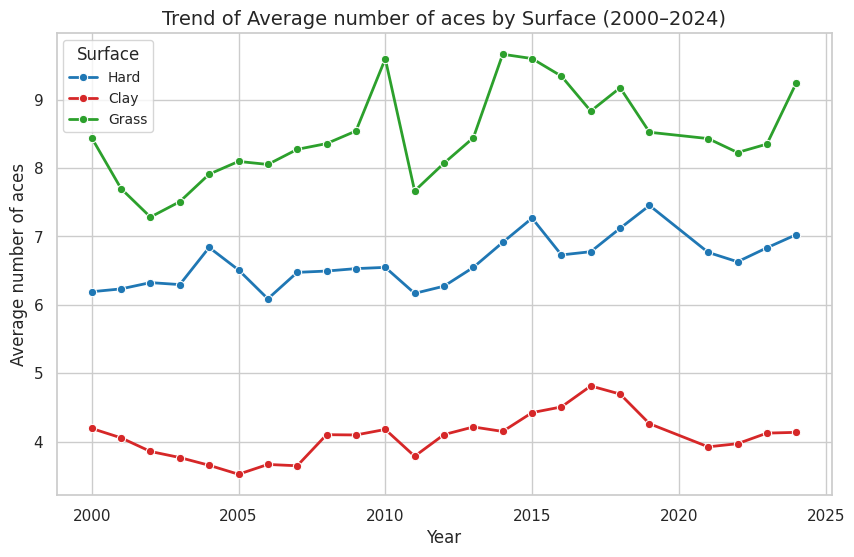

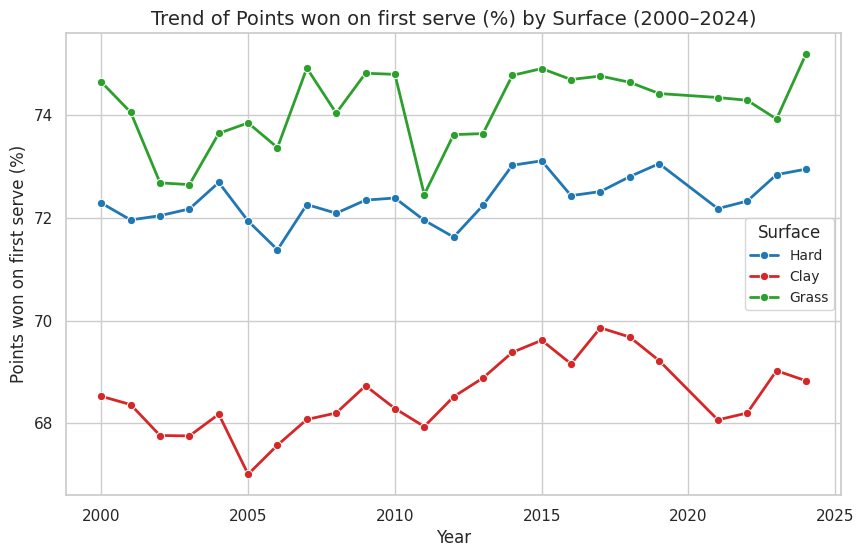

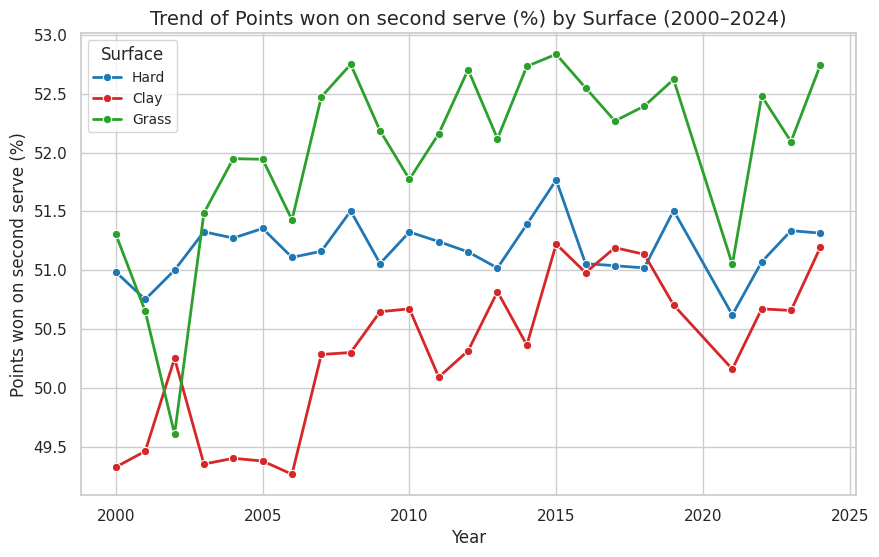

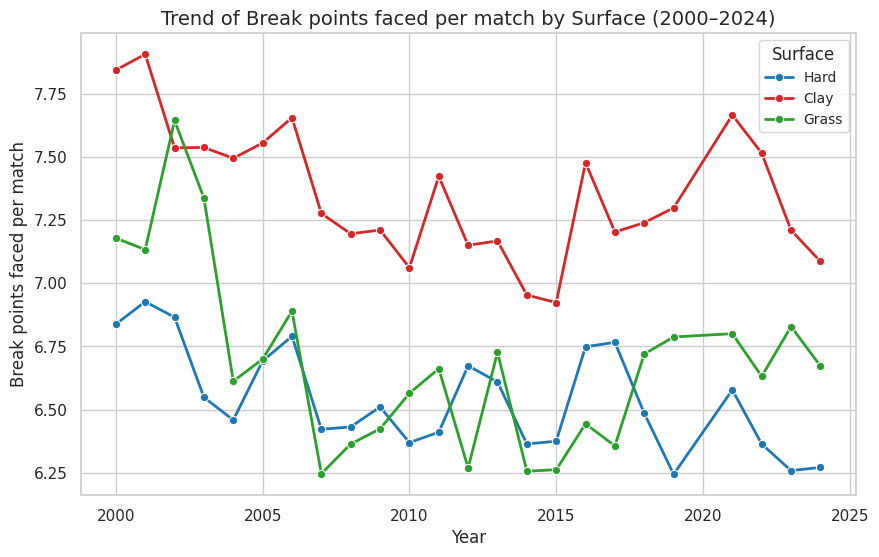

In [129]:

sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (10, 6), 'lines.linewidth': 2})

# Color palette for surfaces
surface_palette = {
    'Hard': '#1f77b4',   # blue
    'Clay': '#d62728',   # red
    'Grass': '#2ca02c'   # green
}

# Function to plot each trend
def plot_surface_trend(variable, ylabel):
    plt.figure()
    sns.lineplot(
        data=players_df,
        x='year', y=variable, hue='surface',
        marker='o', ci=None, palette=surface_palette
    )
    plt.title(f'Trend of {ylabel} by Surface (2000–2024)', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(title='Surface', fontsize=10)
    plt.show()

# Aces per match
plot_surface_trend('ace', 'Average number of aces')

# Points won on first serve
plot_surface_trend('1stWon%', 'Points won on first serve (%)')

# Points won on second serve
plot_surface_trend('2ndWon%', 'Points won on second serve (%)')

# Break points faced
plot_surface_trend('bpFaced', 'Break points faced per match')


## 🧠 Feature Importance by Year and Surface

To study how the game evolved over time, we train a **Random Forest** model for each year (2000–2024, excluding 2020) and surface (**Clay**, **Hard**, **Grass**).

For each model, we record the relative importance of key match features:
`ace`, `df`, `1stServe%`, `1stWon%`, `2ndWon%`, `bpSaved%`, `ServicePointsWon%`, `ReturnPointsWon%`.

This allows us to track how the factors influencing match outcomes have changed through the years on different surfaces.


In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

features = [
    'ace', 'df', '1stServe%', '1stWon%', '2ndWon%',
    'bpSaved%', 'ServicePointsWon%', 'ReturnPointsWon%'
]

years = sorted(players_df['year'].unique())
surfaces = ['Clay', 'Hard', 'Grass']

importance_list = []

for surface in surfaces:
    for year in years:
        df_temp = players_df[(players_df['surface'] == surface) & (players_df['year'] == year)]
        if len(df_temp) < 200:  # skip years with too few matches
            continue

        X = df_temp[features].dropna()
        y = df_temp.loc[X.index, 'result']

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        model = RandomForestClassifier(n_estimators=300, random_state=24)
        model.fit(X_scaled, y)

        temp_importance = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_,
            'Surface': surface,
            'Year': year
        })
        importance_list.append(temp_importance)

# Combine all results
importance_df = pd.concat(importance_list, ignore_index=True)



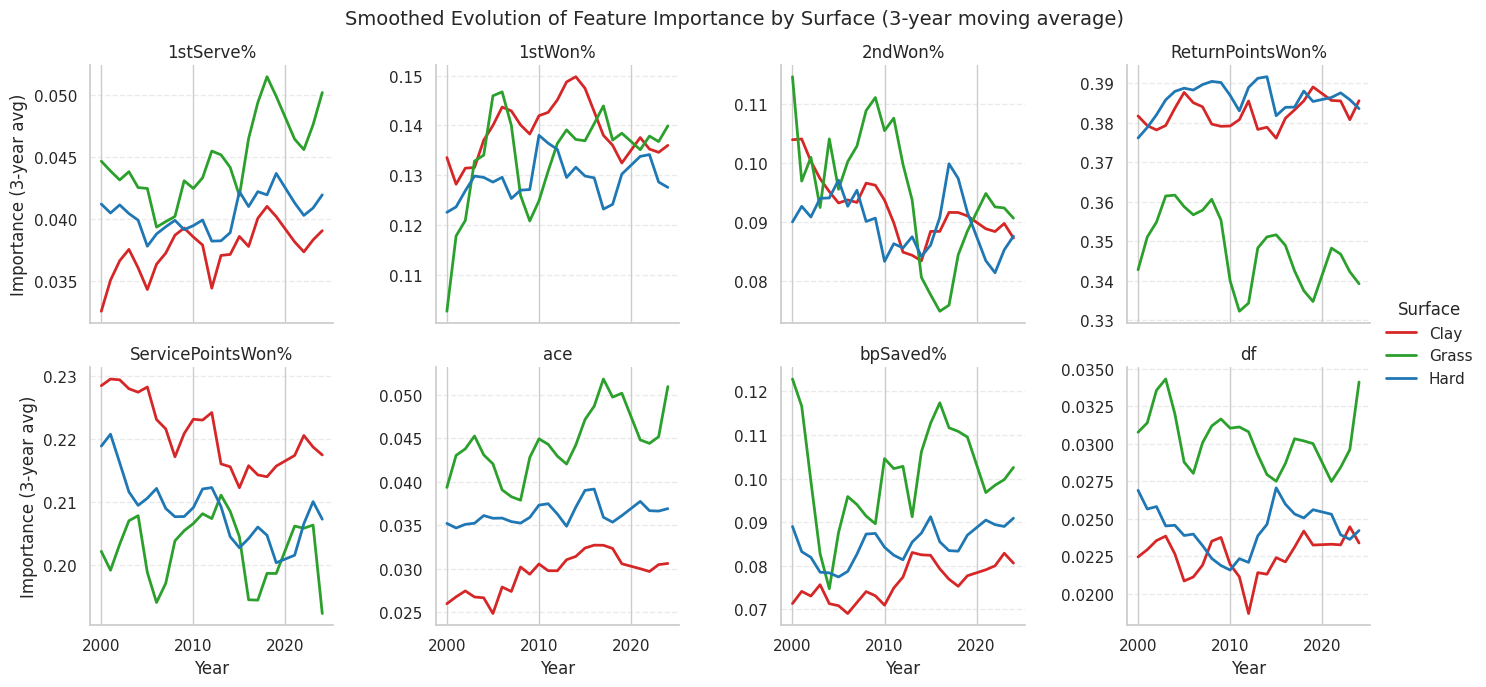

In [131]:
# Compute 3-year moving average for each feature and surface
importance_df = (
    importance_df
    .sort_values(by=['Surface', 'Feature', 'Year'])
    .assign(
        Importance_MA3 = importance_df
        .groupby(['Surface', 'Feature'])['Importance']
        .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    )
)

# FACET PLOT with smoothed trends
g = sns.FacetGrid(
    importance_df,
    col="Feature", col_wrap=4,
    sharey=False, height=3.5,
    hue="Surface", palette=surface_palette
)

g.map(sns.lineplot, "Year", "Importance_MA3", marker=None)
g.add_legend(title="Surface")

# Formatting
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "Importance (3-year avg)")
for ax in g.axes.flatten():
    ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Smoothed Evolution of Feature Importance by Surface (3-year moving average)", fontsize=14)
plt.show()



## 🏁 Conclusions

Serve-related metrics such as *ServicePointsWon%* and *1stWon%* have increased in importance on every surface,  
while return and break-point features have slightly declined.  
This confirms that **serve effectiveness remains the key factor** in modern tennis.

Interestingly, this happens **despite the general slowdown of court surfaces**,  
introduced to limit serve dominance.  
The data suggest that the growing **power and athleticism** of players  
have more than compensated for slower conditions —  
keeping the serve as a decisive weapon across all surfaces.
